# Building a Multiscale Model of the Lac Operon in a Community of Growing, Dividing Bacteria using Vivarium

This notebook outlines how a full multiscale model of a biological process fits together in Vivarium by coupling a Chemical Reaction Network (CRN) model of the Lac Operon to a flux balance metabolic model inside an ensemble of growing dividing cells. 

Briefly, the Lac Operon is the genetic regulatory element in _E. coli_ responsible for enabling lactose metabolism in the absence of glucose. In this notebook, two Lac Operon models are compared. The first uses a deterministic Chemical Reaction Network and the second uses a stochastic Chemical Reaction Network. These models are imported into Vivarium via the Vivarium-Bioscrape package as [SBML models](LINK). An [accompanying notebook](LINK) contains code creating these models and defining all parameters.

Flux Balance Analysis (FBA) is numerical technique for simulating large metabolic networks at steady state. In this example, a flux balance model of _E. coli's_ metabolism is loaded into Vivarium-Cobra from a .BIG file.

### The Organization of this Notebook
Each individual element of the model listed below is simulated and run on its own using a variety of helper functions defined in a [seperate python file](LINK). Then, these elements are combined together to construct a full multiscale model highlighting the power of Vivarium-collective. At each step along the way, the simulation output of the components is plotted along with the topologies of the Vivarium models (graphical representations of the Processes and Stores used internally). This notebook is not intended to be a tutorial on how to use Vivarium (although the seperate python wrapper functions are useful as examples). Instead, this notebook aims to highlight how Processes, Stores, and Agents are connected together via the Vivarium framework.

* 1.1 A Cobra FBA model of _E. coli_ metabolism
* 1.2 Adding derivers to a Cobra FBA model to compute biomass
* 2.1 A deterministic CRN model of the Lac Operon
* 2.2 A stochastic CRN model of the Lac Operon
* 3.1 Multi-agent simulations of growing and diving cells
* 3.2 A lattice model of diffusion
* 3.3 Multiple Agents interacting on a Lattice
* 4.1 Coupling Bioscrape and Cobra in a single deterministic cell
* 4.2 Coupling Bioscrape and Cobra in a single stochastic cell
* 4.3 Coupling Bioscrpae and Cobra in an ensemble of growing, dividing, deterministic cells
* 4.4 Coupling Bioscrpae and Cobra in an ensemble of growing, dividing, stochastic cells
* 4.5 Coupling Bioscrpae and Cobra in an ensemble of growing, dividing, deterministic cells on a lattice
* 4.6 Coupling Bioscrpae and Cobra in an ensemble of growing, dividing, stochastic cells on a lattice

# 1. Flux Balance Analysis Process using Cobra Overview

ERAN TODO

## 1.1  Cobra FBA of _E. coli_ Metabolism

In this first example, a .BIG model is loaded into a Vivarium-Cobra process and simulated. The topology shows how a Process, cobra, is exposed via Stores so it can be linked to other Processes.

In [1]:
%matplotlib inline
from bioscrape_cobra.simulate import simulate_cobra
from bioscrape_cobra.plot import plot_metabolism, cobra_topology_config
from vivarium.plots.topology import plot_topology
from vivarium.plots.simulation_output import save_fig_to_dir

#Simulate Cobra
cobra_timeseries, cobra = simulate_cobra(total_time = 200)


Experiment ID: 867c6c46-99a0-11eb-91e6-ec5c68628376
Created: 04/09/2021 at 19:00:29
Completed in 0.573466 seconds


Writing out/cobra_topology.pdf


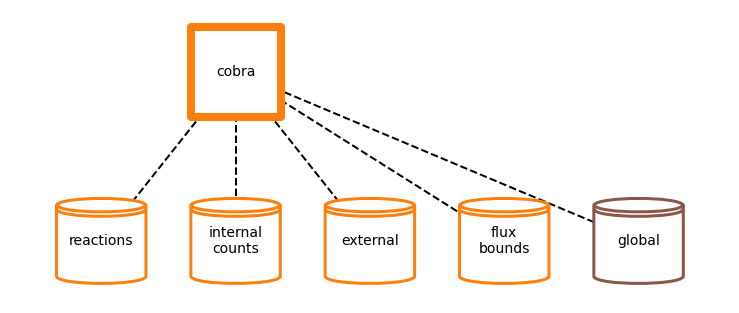

In [2]:
#Plot the Simulation Topology
fig_topology = plot_topology(cobra, cobra_topology_config)
save_fig_to_dir(fig_topology, 'cobra_topology.pdf')

Writing out/cobra_output.pdf


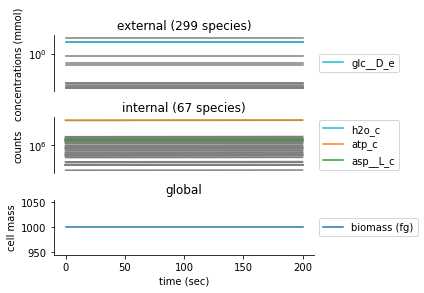

In [3]:
#Plot the Simulation Output
fig_timeseries = plot_metabolism(cobra_timeseries)
save_fig_to_dir(fig_timeseries, 'cobra_output.pdf')

## 1.2 Adding a Derivers to Update Biomass and Volume

On it's own, Cobra does not have a notion of total biomass or cell volume. In this example, two Derivers are connected to a cobra process to automatically compute biomass and cell volume from the output of a metabolic model.

In [4]:
%matplotlib inline
from bioscrape_cobra.simulate import simulate_cobra_composite
from bioscrape_cobra.plot import plot_metabolism
from vivarium.plots.topology import plot_topology

#Simulate Cobra Composite
cobra_timeseries, cobra_composite = simulate_cobra_composite(total_time = 2500)


Experiment ID: 8a342790-99a0-11eb-acf0-ec5c68628376
Created: 04/09/2021 at 19:00:35
Completed in 9.91 seconds


Writing out/cobra_composite_topology.pdf


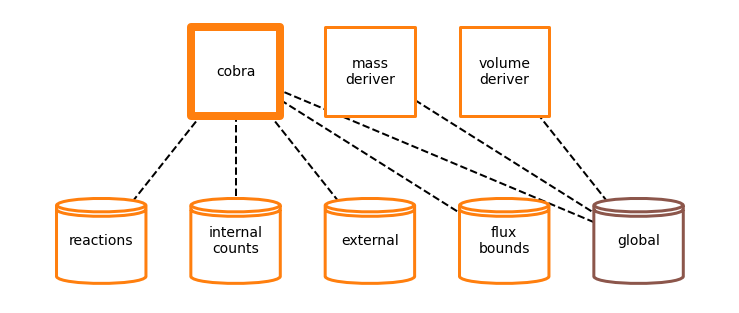

In [5]:
#Plot the Topology
fig_topology = plot_topology(cobra_composite, cobra_topology_config)
save_fig_to_dir(fig_topology, 'cobra_composite_topology.pdf')

Writing out/cobra_composite_output.pdf


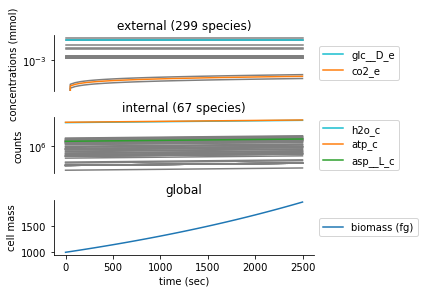

In [6]:
#Plot the Simulation Output
fig_timeseries = plot_metabolism(cobra_timeseries)
save_fig_to_dir(fig_timeseries, 'cobra_composite_output.pdf')

# 2. Simulating Chemical Reaction Network Models of the Lac Operon with Bioscrape Overview

Chemical Reaction Networks (CRNs) are a widely used model in synthetic and systems biology. Briefly, CRNs mechanistically model chemical reactions represented as networks of reactions: $I_r \to O_r$ with rate $k_r(X)$. Here, $I_r$ are the input species, $O_r$ are the output species, and $k_r(X)$ is the rate function. CRNs can be simulated deterministically as sysems of ODEs or stochastically as Markov jump processes. In the follow example, roughly the same set of reactions are used to produce determinist and stochastic models of the Lac Operon which are simulated with [Bioscrape](https://github.com/biocircuits/bioscrape). These models differ in a few reactions (dilution is not included in the stochastic model, because cell division will take care of that) and different units for rate constants (the deterministic model uses molar concentrations, the stochastic model molecular counts).

The lac operon consists of the genetic regulatory elements that control lactose metabolism in _E. coli_. Briefly, the lac operon contains genes which control the metabolism and importation of lactose. This operon is repressed by lacR which is deactivated by allolactose (a biproduct of lactose metabolism). Furthermore, the membrane transporter lactose permease is inhbited by glucose. In the precesence of glucose, lactose will neither be imported nor metabolized. However, in the abscence of glucose and presence of lactose, this operon turns on allowing the cell to metabolize lactose. More details on the model including references and parameter values can be found in [this notebook](https://github.com/vivarium-collective/vivarium-notebooks/blob/main/notebooks/Lac_Operon_CRN.ipynb) used to create the models below.

## 2.1 A Deterministic Bioscrape Simulation of the Lac Operon CRN
In this example, an SBML model is loaded into Vivarium-Bioscrape and simulated deterministically. Once again, the topology shows how the Stores that expose the internal chemical reaction network.

In [7]:
%matplotlib inline
from bioscrape_cobra.simulate import simulate_bioscrape
from vivarium.plots.simulation_output import save_fig_to_dir
from vivarium.plots.topology import plot_topology
from bioscrape_cobra.plot import plot_single, bioscrape_topology_config

#Simulate the Lac Operon CRN Deterministically
bioscrape_timeseries_det, bioscrape_composite_det = simulate_bioscrape(
    total_time = 10000, initial_glucose = 20, initial_lactose = 20)


Experiment ID: 91ed2358-99a0-11eb-bbc9-ec5c68628376
Created: 04/09/2021 at 19:00:48
Completed in 1.23 seconds


Writing out/bioscrape_topology.pdf


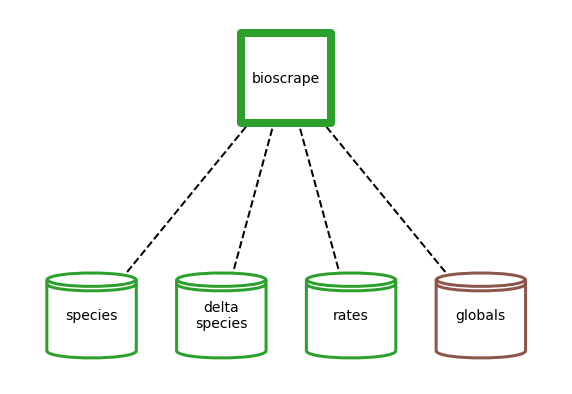

In [8]:
#plot the Topology
fig_topology = plot_topology(bioscrape_composite_det, bioscrape_topology_config)
save_fig_to_dir(fig_topology, 'bioscrape_topology.pdf')

Writing out/bioscrape_deterministic_output.pdf


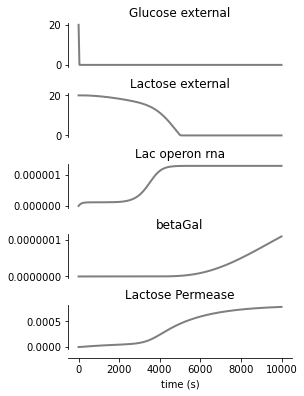

In [9]:
#Plot the CRN Trajectory
species_to_plot = [
    {'variable': ('species', 'Glucose_external'), 'display': 'Glucose external'}, 
    {'variable': ('species', 'Lactose_external'), 'display': 'Lactose external'}, 
    {'variable': ('species', 'rna_M'), 'display': 'Lac operon rna'},
    {'variable': ('species', 'protein_betaGal'), 'display': 'betaGal'},
    {'variable': ('species', 'protein_Lactose_Permease'), 'display': 'Lactose Permease'}
]

fig_timeseries = plot_single(
    bioscrape_timeseries_det, 
    variables = species_to_plot)
save_fig_to_dir(fig_timeseries, 'bioscrape_deterministic_output.pdf')

## 2.2 A Stochastic Bioscrape Simulation of the Lac Operon CRN
In this follow-up example, a stochastic version of the Lac Operon CRN is simulated. This model is similar to the deterministic version. The two major changes are 1. there is no degredation via dilution in this model, because that is assumed to occur via cell division and 2. the parameters have been changed to reflect units of counts instead of molar concentrations. Indeed, these models are so similar that only the underlying bioscrape Process has changed and their Composite topology is identical.

In [ ]:
%matplotlib inline
from bioscrape_cobra.simulate import simulate_bioscrape
from vivarium.plots.topology import plot_topology
from bioscrape_cobra.plot import plot_single, bioscrape_topology_config

#Simulate the Lac Operon CRN Stochastically
bioscrape_timeseries_stoch, bioscrape_composite_stoch = simulate_bioscrape(
    total_time = 10000, stochastic = True, initial_glucose = 500*6.22*10**6, initial_lactose = 500*6.22*10**6)


Experiment ID: 930d375e-99a0-11eb-8803-ec5c68628376
Created: 04/09/2021 at 19:00:50


In [ ]:
fig_topology = plot_topology(bioscrape_composite_stoch, bioscrape_topology_config)

In [ ]:
#Plot a Stochastic Trajectory
species_to_plot = [
    {'variable': ('species', 'Glucose_external'), 'display': 'Glucose external'}, 
    {'variable': ('species', 'Lactose_external'), 'display': 'Lactose external'}, 
    {'variable': ('species', 'rna_M'), 'display': 'Lac operon rna'},
    {'variable': ('species', 'protein_betaGal'), 'display': 'betaGal'},
    {'variable': ('species', 'protein_Lactose_Permease'), 'display': 'Lactose Permease'}
]

fig_timeseries = plot_single(
    bioscrape_timeseries_stoch, 
    variables = species_to_plot)
save_fig_to_dir(fig_timeseries, 'bioscrape_stochastic_output.pdf')

# 3. Multibody and Spatial Simulations

[Vivarium Multibody](LINK) comes with many helpful processes to add interacting physical agents to other simulations. Some of these are detailed below.

## 3.1 Growing and Dividing Cells
In this example, an ensemble of exponentially growing and dividing cells is modeled. The growth Process in this model will later be replaced by Cobra's metabolism. Two topology plots are show. The first shows a single agent and the second shows the full topology for two agents. Because each agent is identifical, in all following notebooks a single topology for agent $n$ will be shown in the convention that this topolology may be replicated many times in the complete model.

In [ ]:
%matplotlib inline
from bioscrape_cobra.simulate import simulate_grow_divide
from vivarium.plots.topology import plot_topology
from bioscrape_cobra.plot import plot_multigen, config_grow_divide_topology_i, config_grow_divide_topology_f

#Simulate Growing, Dividing Cells
grow_divide_timeseries, grow_divide_composite_intial, grow_divide_composite_final = simulate_grow_divide(
    total_time = 100, growth_rate = .006, growth_noise = .005)

In [ ]:
#Plot The Initial Topology
fig_topology = plot_topology(grow_divide_composite_intial, config_grow_divide_topology_i)
save_fig_to_dir(fig_topology, 'grow_divide_topology_1.pdf')

In [ ]:
#Plot The Initial Topology
fig_topology = plot_topology(grow_divide_composite_final, config_grow_divide_topology_f)
save_fig_to_dir(fig_topology, 'grow_divide_topology_2.pdf')

In [ ]:
#Plot Cell Trajectories
fig_trajectories = plot_multigen(grow_divide_timeseries, variables = [("boundary", "mass"), ("boundary", "volume")])
save_fig_to_dir(fig_trajectories, 'grow_divide_output.pdf')

## 3.2 A Lattice Model of Diffusion

In this example, a very simple model of diffusion is simulated on a lattice.

In [ ]:
%matplotlib inline
from bioscrape_cobra.simulate import simulate_diffusion
from vivarium.plots.topology import plot_topology
from vivarium_multibody.plots.snapshots import plot_snapshots, format_snapshot_data
from bioscrape_cobra.plot import config_diffusion_topology
import numpy as np
import matplotlib as plt

#Grid Size
N = 10
diffusion_bounds = [N, N]

#Set up a positive initial state
initial_state = np.zeros((N, N))
initial_state[3, 6] = 100
initial_state[3, 7] = 50
initial_state[6, 6] = 100
initial_state[6, 7] = 50
initial_state[2, 4] = 100
initial_state[2, 3] = 25
initial_state[3, 3] = 100
initial_state[3, 2] = 25
initial_state[4, 2] = 100
initial_state[5, 2] = 100
initial_state[6, 2] = 25
initial_state[6, 3] = 100
initial_state[7, 3] = 25
initial_state[7, 4] = 100

#Simulate diffusion
diffusion_data, diffusion_composite = simulate_diffusion(
    total_time = 200, 
    initial_state = initial_state, 
    bounds = diffusion_bounds,
    diffusion_rate = .005)

In [ ]:
#Plot Topology
fig_topology = plot_topology(diffusion_composite, config_diffusion_topology)
save_fig_to_dir(fig_topology, 'diffusion_topology.pdf')

In [ ]:
#Reformat Data
agents, fields = format_snapshot_data(diffusion_data)

#Plot Simulation Snapshots
fig2 = plot_snapshots( 
    bounds=diffusion_bounds,
    fields=fields,
    agents=agents,
    n_snapshots=4)
save_fig_to_dir(fig2, 'diffusion_output.pdf')

## 3.3 Adding Multibody Physics to the Lattice
In this example, multibody, a wrapper around the [pymonk physics engine]() is added to the model. This produces an extra Process. However, without physical agents, there is no new simulation output to display.

In [ ]:
#Plot Lattice topology
from bioscrape_cobra.simulate import Lattice
from bioscrape_cobra.plot import config_lattice_topology

lattice_composer = Lattice()
fig_topology = plot_topology(lattice_composer, config_lattice_topology)
save_fig_to_dir(fig_topology, 'lattice_topology.pdf')

## 3.3 Placing Agents on the Lattice

In this example, multiple Agents (exponentially growing and dividing cells) are placed together on a lattice with diffusion and solid-body physics interactions.

In [ ]:
from bioscrape_cobra.simulate import simulate_grow_divide_lattice, get_lattice_grow_divide_composite
from vivarium.plots.topology import plot_topology
from vivarium_multibody.plots.snapshots import plot_snapshots, format_snapshot_data
from bioscrape_cobra.plot import config_grow_divide_lattice_topology
import numpy as np

#Grid Size
N = 20
bounds = [N, N]
#Set up a positive initial state
initial_state = np.zeros((N, N))
initial_state[0, 0] = 100
initial_state[0, -1] = 100
initial_state[-1, 0] = 100
initial_state[-1, -1] = 100

#Create the a Composite with Agents (Cells) on a Lattice
lattice_grow_divide_composite = get_lattice_grow_divide_composite(
    bounds = bounds, 
    bins = bounds,
    initial_concentration = initial_state,
    diffusion_rate = .01)

#Plot the topology

fig_topology = plot_topology(lattice_grow_divide_composite, config_grow_divide_lattice_topology)
save_fig_to_dir(fig_topology, 'grow_divide_lattice_topology.pdf')

In [ ]:
#Simulate the Composite
lattice_grow_divide_data = simulate_grow_divide_lattice(lattice_grow_divide_composite, total_time = 150)

In [ ]:
#Plot snapshots of the simulation
agents, fields = format_snapshot_data(lattice_grow_divide_data)

fig2 = plot_snapshots( 
    bounds=bounds,
    fields=fields,
    agents=agents,
    n_snapshots=4)
save_fig_to_dir(fig2, 'grow_divide_lattice_output.pdf')

# 4. Connecting Bioscrape and COBRA in Lineage of Growing and Dividing cells on a Lattice.

## 4.1 Bioscrape and COBRA in a Single Deterministic Cell

In this example, Bioscrape and COBRA are connected to simulate a deterministic version of the Lac Operon coupled to the FBA model. The flux of lactose entering the cell and the metabolic flux of lactose metabolism due to $\beta$-
galactosidase are computed using the CRN model and then used to tightly bound the FBA optimization. In turn, FBA computes the overall growth rate of the cell, which is then fed back into the CRN model as a dilution rate. In the topology, notice that much of the complexity comes from different adaptors to compute things like fluxes and dilutions rates (effectively these are unit conversations allowing the two modules to communicate).

In [ ]:
from bioscrape_cobra.bioscrape_cobra_deterministic import BioscrapeCOBRAdeterministic
from bioscrape_cobra.simulate import get_bioscrape_cobra_config, simulate_bioscrape_cobra, plot_variables_list_deterministic
from bioscrape_cobra.plot import plot_single, config_single_cell_bioscrape_cobra_topology
from vivarium.plots.topology import plot_topology

# Show full topology here
#TODO wrap this so I can get the Composite before simulating
#bsc_composite_det = BioscrapeCOBRAdeterministic(get_bioscrape_cobra_config())

biocobra_data_det, comp0_det = simulate_bioscrape_cobra(
    initial_glucose=500, #mM
    initial_lactose=500, #mM
    total_time = 20000, 
    output_type='timeseries')

In [ ]:
fig_topology = plot_topology(comp0_det, config_single_cell_bioscrape_cobra_topology)
save_fig_to_dir(fig_topology, 'bioscrape_cobra_deterministic_topology.pdf')

In [ ]:
fig_data = plot_single(biocobra_data_det, variables = plot_variables_list_deterministic)
save_fig_to_dir(fig_data, 'bioscrape_cobra_deterministic_output.pdf')

## 4.2 Bioscrape and COBRA in a Single Stochastic Cell

Similar to the previous example, here Bioscrape and Cobra are connected using a stochastic CRN model. Running this simulation multiple times will result in distinct trajectories of a single cell. The connections between FBA and the CRN model are identical to the previous model, except that there is no dilution rate in this CRN, so that connection has been removed. In the topology, notice that just by switching from a deterministic to stochastic model a number of different Adaptors and Derivers were needed to deal with unit conversions.

In [ ]:
from bioscrape_cobra.bioscrape_cobra_stochastic import BioscrapeCOBRAstochastic
from bioscrape_cobra.simulate import get_bioscrape_cobra_config, simulate_bioscrape_cobra, plot_variables_list_stochastic
from bioscrape_cobra.plot import plot_single, config_single_cell_bioscrape_cobra_topology
from vivarium.plots.topology import plot_topology

# from bioscrape_cobra import helper

# Show full topology here
#TODO wrap this so I can get the Composite before simulating
#bsc_composite_stoch = BioscrapeCOBRAstochastic(get_bioscrape_cobra_config())

#Simulate
biocobra_data_stoch, comp0_stoch = simulate_bioscrape_cobra(
    initial_glucose=500, #concentration
    initial_lactose=500, #concentration
    total_time = 10000, 
    output_type='timeseries',
    stochastic = True)

In [ ]:
#plot the topology
fig_topology = plot_topology(comp0_stoch, config_single_cell_bioscrape_cobra_topology)
save_fig_to_dir(fig_topology, 'bioscrape_cobra_stochastic_topology.pdf')

In [ ]:
#plot the simulation data
fig_data = plot_single(biocobra_data_stoch, variables = plot_variables_list_stochastic)
save_fig_to_dir(fig_data, 'bioscrape_cobra_stochastic_output.pdf')

## 4.3 Bioscrape and COBRA in an Lineage of Deterministic Cells
This example shows an ensemble of growing divide cells each with its own internal CRN and FBA model. As the cells grow, they will eventually trigger a division process when a volume threshold is reached. Each of these cells has an identical trajectory because the simulation is completely deterministic. Finally, notice that the topology in the deterministic bioscrape-COBRA model is effectively replicated for each agent. The boundary stores (brown) are how agents communicate with eachother and their environment.

In [ ]:
%matplotlib inline
from bioscrape_cobra.bioscrape_cobra_deterministic import BioscrapeCOBRAdeterministic
from bioscrape_cobra.simulate import get_bioscrape_cobra_config, simulate_bioscrape_cobra, plot_variables_list_deterministic
from bioscrape_cobra.plot import plot_multigen, config_embedded_bioscrape_cobra_topology
from vivarium.plots.topology import plot_topology
from vivarium.library.units import units

#bsc_composite_det_div = BioscrapeCOBRAdeterministic(get_bioscrape_cobra_config(division = True))

#plot the topology
#Simulate
biocobra_data_det_div, comp0_det_div = simulate_bioscrape_cobra(
    total_time = 20000,
    initial_glucose=500, #mM
    initial_lactose=500, #mM
    divide_threshold=2000 * units.fg, #how big a cell is when it divides
    halt_threshold = 4, #maximum total cells to simulate
    output_type='unitless', 
    division = True)



In [ ]:
fig_topology = plot_topology(comp0_det_div, config_embedded_bioscrape_cobra_topology)
save_fig_to_dir(fig_topology, 'bioscrape_cobra_deterministic_divide_topology.pdf')

In [ ]:
#plot the simulation
fig_data = plot_multigen(biocobra_data_det_div)
save_fig_to_dir(fig_data, 'bioscrape_cobra_deterministic_divide_output.pdf')

## 4.4 Bioscrape and COBRA in an Lineage of Stochastic Cells
This example shows an ensemble of growing divide cells each with its own internal stochastic CRN and FBA model. As the cells grow, they will eventually trigger a division process when a volume threshold is reached. Unlike the previous example, each cell in this ensemble will have a unique trajectory due to the stochasticity of its internal CRN. Finally, in the topology notice that the topology in the stochastic bioscrape-COBRA model is effectively replicated for each agent. The boundary stores (brown) are how agents communicate with eachother and their environment.

In [ ]:
%matplotlib inline
from bioscrape_cobra.bioscrape_cobra_stochastic import BioscrapeCOBRAstochastic
from bioscrape_cobra.simulate import get_bioscrape_cobra_config, simulate_bioscrape_cobra, plot_variables_list_stochastic
from bioscrape_cobra.plot import plot_multigen, config_embedded_bioscrape_cobra_topology
from vivarium.plots.topology import plot_topology
from vivarium.library.units import units

#Simulate
biocobra_data_stoch_div, comp0_stoch_div = simulate_bioscrape_cobra(
    total_time = 20000,
    initial_glucose=500,  # mM
    initial_lactose=500,  # mM
    divide_threshold=2000 * units.fg, #how big a cell is when it divides
    halt_threshold = 4, #maximum total cells to simulate
    output_type='unitless', 
    division = True,
    stochastic = True)

In [ ]:
fig_topology = plot_topology(comp0_stoch_div, config_embedded_bioscrape_cobra_topology)
save_fig_to_dir(fig_topology, 'bioscrape_cobra_stochastic_divide_topology.pdf')

In [ ]:
#Plot the Simulation
fig_data = plot_multigen(biocobra_data_stoch_div)
save_fig_to_dir(fig_data, 'bioscrape_cobra_stochastic_divide_output.pdf')

## 4.5 Bioscrape and COBRA in an Lineage of Deterministic Cells on a Lattice
In this example, a lineage of deterministic cells each containing a Bioscrape-cobra model are simulated on a lattice. As the cells deplete the local concentrations of glucose and lactose, these molecules will be replenished (up to a point) from the surrounding environment due to diffusion. When cells divide, they interact with eachother physically displacing eachother to new locations on the lattice. The topology is almost identical to the previous example, except for the addition of the diffusion and multibody Processes which govern interactions between agents and the environment. Despite being a deterministic simulation, each cell interacts with different parts of its environment, giving rise to variation in the cells internal state (illustrated by the internal color of the final plot which represents the amount of lactose permease in each cell).


In [ ]:
%matplotlib inline 
import pylab as plt
from bioscrape_cobra.bioscrape_cobra_deterministic import BioscrapeCOBRAdeterministic
from bioscrape_cobra.simulate import get_bioscrape_cobra_config, simulate_bioscrape_cobra, plot_variables_list_deterministic
from bioscrape_cobra.plot import plot_fields_snapshots, plot_fields_tags, config_embedded_bioscrape_cobra_topology
from vivarium.plots.topology import plot_topology
from vivarium.library.units import units


#Simulate
bounds = [10, 10]
biocobra_data_det_div_spa, comp0_det_div_spa = simulate_bioscrape_cobra(
    total_time = 4000,
    initial_glucose=10, #mM
    initial_lactose=10, #mM
    divide_threshold=2000 * units.fg, #how big a cell is when it divides
    halt_threshold = 8, #maximum total cells to simulate
    bounds = bounds, #size of the lattice (microns)
    n_bins = [10, 10] , #number of lattice grid points
    output_type='unitless', 
    division = True,
    spatial = True)


In [ ]:
fig_topology = plot_topology(comp0_det_div_spa, config_embedded_bioscrape_cobra_topology)
save_fig_to_dir(fig_topology, 'bioscrape_cobra_deterministic_lattice_topology.pdf')

In [ ]:
#Plot
fig_snapshots = plot_fields_snapshots(
    biocobra_data_det_div_spa,
    bounds=bounds,
    include_fields=['Glucose_external', 'Lactose_external'])
save_fig_to_dir(fig_snapshots, 'bioscrape_cobra_deterministic_lattice_snapshots.pdf')
plt.show()

fig_tags = plot_fields_tags(
    biocobra_data_det_div_spa,
    bounds=bounds,
    tagged_molecules=[('species', 'protein_Lactose_Permease',)])
save_fig_to_dir(fig_tags, 'bioscrape_cobra_deterministic_lattice_tags.pdf')
plt.show()

## 4.6 Bioscrape and COBRA in an Lineage of Stochastic Cells on a Lattice

In this example, a lineage of stochastic cells each containing a Bioscrape-cobra model are simulated on a lattice. As the cells deplete the local concentrations of glucose and lactose, these molecules will be replenished (up to a point) from the surrounding environment due to diffusion. When cells divide, they interact with eachother physically displacing eachother to new locations on the lattice. The topology is almost identical to the previous example, except for small changes in the adaptors and derivers needed for stochastic simulation. In the simulation snapshots, notice the cells have different internal colors in the final plot (representing the amount of Lactose Permease). This hetereogeneity occurs due to the stochasticity in the model of the Lac operon and variability in the environment.

In [ ]:
%matplotlib inline
import pylab as plt
from bioscrape_cobra.bioscrape_cobra_stochastic import BioscrapeCOBRAstochastic
from bioscrape_cobra.simulate import get_bioscrape_cobra_config, simulate_bioscrape_cobra, plot_variables_list_deterministic
from bioscrape_cobra.plot import plot_fields_snapshots, plot_fields_tags
from vivarium.plots.topology import plot_topology
from vivarium.library.units import units


# Show full topology here
#TODO wrap this so I can get the Composite before simulating
#bsc_composite_stoch_div_spa = BioscrapeCOBRAstochastic(get_bioscrape_cobra_config(division = True, spatial = True))

#Simulate
bounds = [10, 10]
biocobra_data_stoch_div_spa, comp0_stoch_div_spa = simulate_bioscrape_cobra(
    total_time = 4000,
    bounds = bounds, #size of the lattice (microns)
    n_bins = [10, 10] , #number of lattice grid points
    initial_glucose=10,
    initial_lactose=10,
    depth=1,
    diffusion_rate=1e-1,
    divide_threshold=2000 * units.fg, #how big a cell is when it divides
    halt_threshold = 8, #how total cells to simulate
    output_type='unitless',
    stochastic = True,
    division = True,
    spatial = True)

In [ ]:
fig_topology = plot_topology(comp0_stoch_div_spa, config_embedded_bioscrape_cobra_topology)
save_fig_to_dir(fig_topology, 'bioscrape_cobra_stochastic_lattice_topology.pdf')

In [ ]:
# Plot
fig_snapshots = plot_fields_snapshots(
    biocobra_data_stoch_div_spa,
    bounds=bounds,
    include_fields=['Glucose_external', 'Lactose_external'])
save_fig_to_dir(fig_snapshots, 'bioscrape_cobra_stochastic_lattice_snapshots.pdf')
plt.show()

fig_tags = plot_fields_tags(
    biocobra_data_stoch_div_spa,
    bounds=bounds,
    tagged_molecules=[('species', 'protein_Lactose_Permease',)])
save_fig_to_dir(fig_tags, 'bioscrape_cobra_stochastic_lattice_tags.pdf')
plt.show()